## Oppgave 3 a)

In [ ]:
import numpy as np
from numba import njit
import math as math
import matplotlib.pyplot as plt

kb = 1.38 * 10**-23
T = 298
beta = 1/(kb*T)


@njit
def walk_dir(p_minus: float, p_plus: float) -> int:
    rand_val = np.random.ranf()
    if rand_val <= p_minus:
        return -1
    elif rand_val >= (1 - p_plus):
        return 1
    else:
        return 0


@njit
def v31(x: int, n_x: int, alpha: float, k: float) -> float:
    x_per = x % n_x
    if x_per < alpha * n_x:
        return k * x_per / (alpha * n_x * beta)
    else:
        x_per = x_per - n_x
        return -k * x_per / ((1 - alpha) * n_x * beta)


@njit
def v32(x: int, n_x: int, alpha: float, k: float) -> float:
    return 1 / beta


@njit
def probs_3(beta: float, v, x: int, n_x: int, alpha: float, k: float, t: int, t_p: int):
    a = -beta * (periodic_pot(t, t_p, x - 1, n_x, alpha, k) - periodic_pot(t, t_p, x + 1, n_x, alpha, k))
    b = -beta * (periodic_pot(t, t_p, x,     n_x, alpha, k) - periodic_pot(t, t_p, x + 1, n_x, alpha, k))
    c = -beta * (periodic_pot(t, t_p, x + 1, n_x, alpha, k) - periodic_pot(t, t_p, x - 1, n_x, alpha, k))
    d = -beta * (periodic_pot(t, t_p, x,     n_x, alpha, k) - periodic_pot(t, t_p, x - 1, n_x, alpha, k))

    if a > 50:
        a = 50
    elif a < -50:
        a = -50
    if b > 50:
        b = 50
    elif b < -50:
        b = -50
    if c > 50:
        c = 50
    elif c < -50:
        c = -50
    if d > 50:
        d = 50
    elif d < -50:
        d = -50

    p_plus = 1.0 / (1.0 + np.exp(a) + np.exp(b))
    p_minus = 1.0 / (1.0 + np.exp(c) + np.exp(d))

    return p_minus, p_plus


@njit
def periodic_pot(t: int, t_p: int, x: int, n_x: int, alpha: float, k: float) -> float:
    if t % (2 * t_p) < t_p:
        return v32(x, n_x, alpha, k)
    else:
        return v31(x, n_x, alpha, k)


@njit
def walk_step(n_x: int, alpha: float, k: float, n_p: int, t: int, t_p: int, x: np.ndarray, interval: int):
    np.random.shuffle(x)
    n_plus = 0
    n_minus = 0
    for j in range(len(x)):
        p_minus, p_plus = probs_3(beta, periodic_pot, x[j], n_x, alpha, k, t, t_p)
        step = walk_dir(p_minus, p_plus)

        if step == 1:
            n_plus += 1
            if x[j] == interval:
                x[j] = 0
            else:
                x[j] += step
        elif step == -1:
            n_minus += 1
            if x[j] == 0:
                x[j] = interval
            else:
                x[j] += step

    return x, (n_plus - n_minus) / n_p


def sim_3(t_p: int, n_x: int, alpha: float, k: float, n_p: int, cycles: int, interval: int):
    x = np.array([[i for _ in range((n_p // interval))] for i in range(n_p // (n_p // interval))]).flatten()
    avg_flow = np.zeros(cycles)

    for cycle in range(cycles):
        flow_t = np.zeros(2 * t_p)
        for t in range(2 * t_p):
            x, flow = walk_step(n_x, alpha, k, n_p, t, t_p, x, interval)
            flow_t[t] = flow
        avg_flow[cycle] = flow_t.sum() / (2 * t_p)

    return x, avg_flow


x_10, avg_flow_08 = sim_3(500, 100, 0.8, 1000, 1200, 10, 200)
x_10, avg_flow_01 = sim_3(500, 100, 0.1, 1000, 1200, 10, 200)




In [ ]:
print(avg_flow_08)
print(avg_flow_01)


[-0.0287525  -0.01137833 -0.0143925  -0.01290583 -0.01156833 -0.01190083
 -0.01206    -0.0120525  -0.0129075  -0.0112275 ]
[0.03981833 0.025035   0.02756333 0.02736917 0.02672833 0.028705
 0.02849583 0.0258725  0.02780583 0.02897917]


### i)
Vi får ikke-null partikkelstrømmer fordi potensial 1 har en positiv derivert for 80% av tall linjen, mot de 20%ene som er dekt av den negative deriverte. Selvom vi gjennom en hel syklus i posisjoner for potensial 1 går fra minimum til maksimum tilbake til minimum, vil vi fortsatt ha flere partikler som beveger seg til venstre for hver iterasjon da sum av skritt ikke er direkte proposjonal med magnitude av gradienten til potensialet ganget med område den dekker.

Fysiskt kan dette forklares med at vi har et område delt inn i mange seksjoner på en meter, der vi kan forskyve inndelingene litt for å få en potensialfunskjon med en dal i hver inndeling der vi starter på -0.2 meter og går til 0.8 osv gjennom område. Her vil potensialet være like maksimalt for -0.2 og 0.8 meter, og gå lineært ned mot minmium ved 0 meter. For å oppnå lavest potensiell energi vil alle partiklene bevege seg til posisjonen ved 0 meter, her kan vi se at hvis partiklene orginalt er jevnt fordelt vil flere partikler gå mot venstre enn høyre, som resulterer i en negativ gjennomsnittlig partikkelflyt ($J_{avg}$).


### ii)
Vi ser at den første målingen av $J_{avg}$ er betydelig større enn alle de andre målingene som er relatvit like. Dette an forklares ved at partiklene orginalt er jevt fordelt for å så bevege seg slik at de i praksis alle er ved minimalt potensial under potensial 1, deretter byttes potensialet til potensial 2 som er konstant, og fører til tilfeldig bevegelse, på grunn av at denne tilfeldige bevegelsen skjer i en veldig begrenset tidsperiode, og at partiklene i utgangspunktet alle er veldig nær posisjon 0, forventer vi at de er betydelig nærmere posisjon 0 enn når de var jevnt fordelte ved tidspunktet der vi bytter tilbake til potensial 1. Dette gjør at vi får mindre bevegelse og derfor en lavere $J_{avg}$.


### iii)
Her ser vi at $J_{avg}$ er mot høyre isteden for venstre (positiv isteden for negativ) som vi forventer da potensial 1 nå har mye større del med negativ derivert enn positiv derivert. 



Oppgave 3 b)

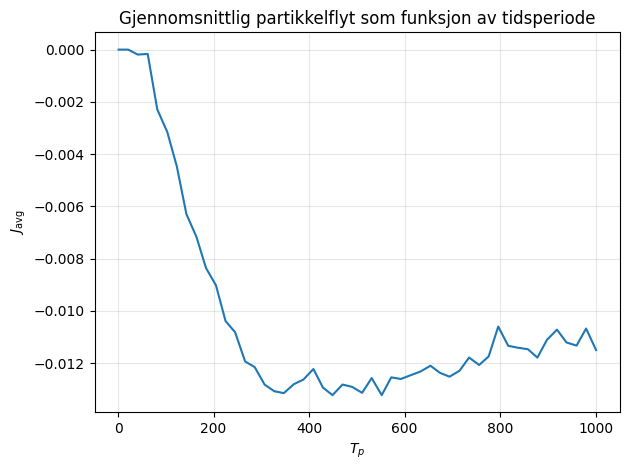

In [ ]:
def sim_3b(t_p: int, n_x: int, alpha: float, k: float,
           n_p: int, cycles: int, pos1: int, pos2: int, interval: int):

    x = np.array([[pos1 for _ in range(n_p // 2)],
                  [pos2 for _ in range(n_p // 2)]]).flatten()

    flow_t = np.zeros(2 * t_p)

    for t in range(2 * t_p):
        x, flow = walk_step(n_x, alpha, k, n_p, t, t_p, x, interval)
        flow_t[t] = flow

    avg_flow = flow_t.sum() / (2 * t_p)
    return x, avg_flow


t_p_array = np.int64(np.linspace(1, 1001, 50))

flow_array_3b = np.zeros(len(t_p_array), dtype=np.float64)

for i in range(len(t_p_array)):
    x, avg_flow_3b = sim_3b(t_p_array[i], 100, 0.8, 1000, 40 * 100, 1, 100, 200, 300)
    flow_array_3b[i] = avg_flow_3b


plt.plot(t_p_array, flow_array_3b)
plt.xlabel(r"$T_p$")
plt.ylabel(r"$J_{\mathrm{avg}}$")
plt.title("Gjennomsnittlig partikkelflyt som funksjon av tidsperiode")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



### i)
Vi observer at magnituden $J_{avg}$ starter rundt null, for å så gå opp til et maksimum ved $T_p \in [350, 550]$, magnituden av flyten minker etter dette. En tolkning av den initielle økningen i magnitude er at partiklene trenger noe tid for å spre seg utover mens potensial 2 er aktivt for at vi skal se noe utslag i $J_{avg}$. Dette kan forklares ved at partiklene vil gå veldig lite vekk fra minimum i potensial 1 ved et lavt antall tidssteg som fører til at veien tilbake til minimum er like lang uavhengig av hvilken ve de gikk da asymmetrien i potensialet i prakisis "ikke oppdages" av partiklene, dette gjør da at $J_{avg}$ blir null.

For å forklare hvorfor magnituden igjen går ned ved en tilstrekkelig høy verdi for $T_p$, kan vi se på formelen for å regne ut $J_{avg}$. Vi har tenkt oss at denne er i noen grad porposjonal med hvor langt partiklene er unna minimumet i potensial 1, dette vil i vårt tilfelle makismeres når partiklene er uniformt fordelt, når vi ser bort fra ekstremt usannsynlige tilfeller. videre vet vi at $J_{avg}$ er lineært omvendtproposjonalt med T_p, mens den gjennomsnittlige avstanden fra en partikkel til minimum i potensial 1 er avvtakende proposjonal $T_p$. Dette gjør at vi vil får en kamp mellom det positive bidraget til magnitudena v flyten fra $T_p$ som har en negativ derivert, og det negative bidraget fra $T_p$ som har en konstant derivert, gitt at det positive bidraget starter større enn det negative må vi da finne et eller annet punkt $T_{p_{maks}} > T_{p_0}$ der magnituden av $J_{avg}$ maksimeres.

## Oppgave 3 c)

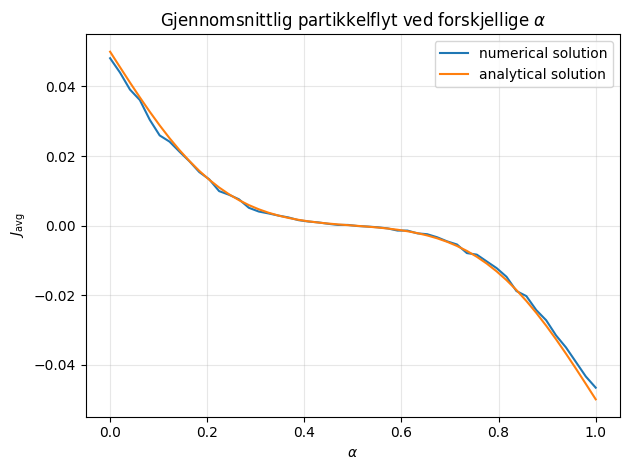

In [ ]:
import math as math

def analytic_flow(n_x: int, t_p: int, alpha: float):
    return n_x/(4*t_p) * (
        math.erfc(alpha*n_x/2*np.sqrt(3/t_p))
        - math.erfc((1-alpha)*n_x/2*np.sqrt(3/t_p))
    )

alpha_array = np.linspace(0, 1, 50)

flow_array_3c = np.zeros(len(alpha_array), dtype=np.float64)
analytic_flow_array_3c = np.zeros(len(alpha_array), dtype=np.float64)

for i in range(len(alpha_array)):
    x, avg_flow = sim_3b(500, 100, alpha_array[i], 1000, 40*100, 1, 100, 200, 300)
    flow_array_3c[i] = avg_flow
    analytic_flow_array_3c[i] = analytic_flow(100, 500, alpha_array[i])

plt.plot(alpha_array, flow_array_3c, label="numerical solution")
plt.plot(alpha_array, analytic_flow_array_3c, label="analytical solution")

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$J_{\mathrm{avg}}$")
plt.title(r"Gjennomsnittlig partikkelflyt ved forskjellige $\alpha$")

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

    

Den nummeriske løsningen vår er veldig lik den analytiske løsningen som tyder på at oppgaven er løst rett. Vi ser en korrelasjon mellom $|\alpha-0.5|$ og magnituden av $J_{avg}$